Resultados comparativos salvos em: C:\Users\leona\pyhtonscripts\ExperimentosTeste\resultadosKfold\resultados_comparativos_janelas.csv

Resultados comparativos por ticker e janela:
     Ticker  Saldo Final Janela_1  Retorno Janela_1 (%)  Saldo Final Janela_2  \
0  PETR4.SA          11702.892681             17.028927          15699.539592   
1  BRFS3.SA          18267.195644             82.671956          16059.337074   
2  VALE3.SA          10000.000000              0.000000           8638.233149   
3  JBSS3.SA          12535.021220             25.350212          10185.854466   
4  SOJA3.SA          14580.656717             45.806567          12002.362831   
5  SUZB3.SA          10782.804559              7.828046          11087.032987   
6  GGBR3.SA          10000.000000              0.000000          10583.549081   
7  CSNA3.SA          14816.405186             48.164052           9413.984297   

   Retorno Janela_2 (%)  
0             56.995396  
1             60.593371  
2           

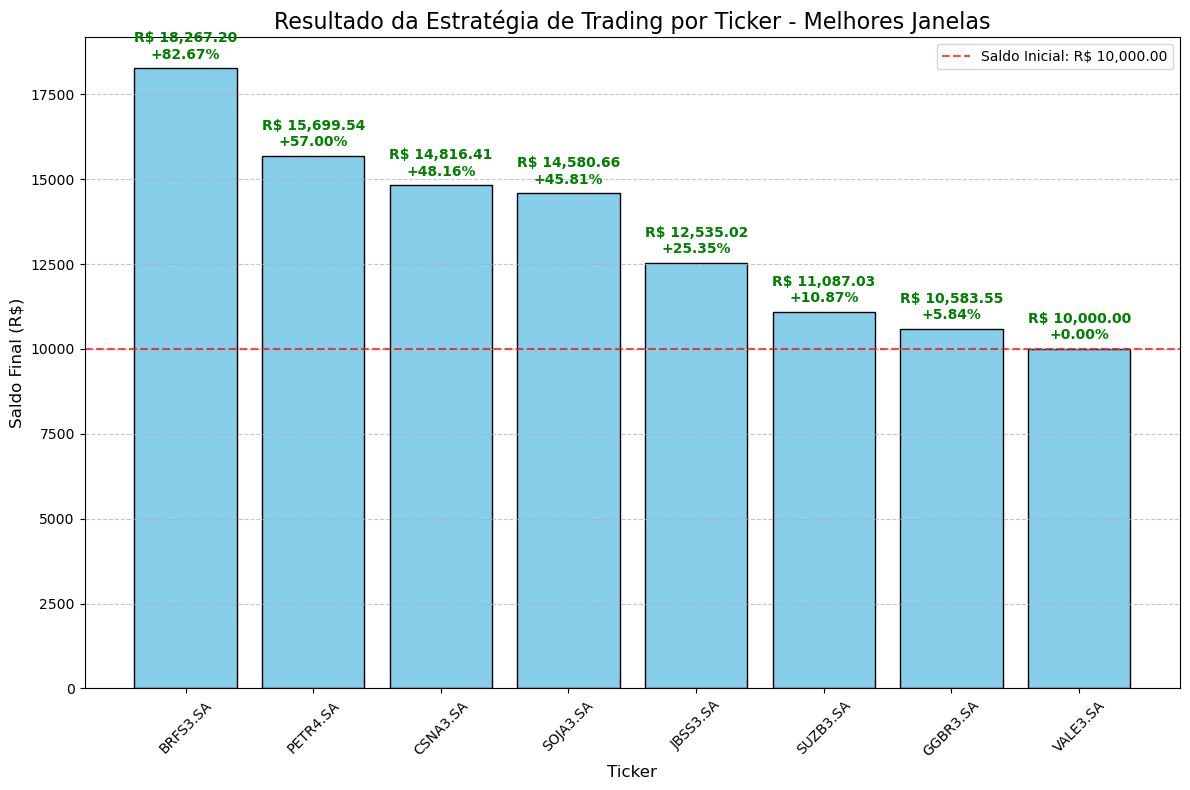


Estatísticas gerais:
Retorno médio: 34.46%
Melhor desempenho: BRFS3.SA com 82.67%
Pior desempenho: VALE3.SA com 0.00%


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Diretório onde estão os arquivos de previsões
input_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\Macro"

# Diretório onde os resultados serão salvos
output_dir = r"c:\Users\leona\pyhtonscripts\ExperimentosTeste\MacroResultados"
os.makedirs(output_dir, exist_ok=True)

# Diretório para salvar as transações
transactions_dir = os.path.join(output_dir, "Transacoes")
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["PETR4.SA", "BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", "SUZB3.SA", "GGBR4.SA", "CSNA3.SA"]

# Lista de janelas
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

# Estratégia "All-In" usando apenas as previsões originais
def estrategia_all_in(dados_brutos, saldo_inicial):
    # Converter colunas para valores numéricos sem substituir as previsões
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')
    
    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = []
    
    # Verificar se as previsões estão dentro de um intervalo realista
    previsoes = dados['Preço Previsto'].dropna()
    if len(previsoes) == 0:
        print(f"Sem previsões válidas para processamento")
        return saldo_inicial, [], {'Estratégia Usada': 'Previsões Inválidas', 'Total de Transações': 0, 'Retorno (%)': 0}
        
    # Verificar se as previsões são válidas (não extremas)
    min_previsao = previsoes.min()
    max_previsao = previsoes.max()
    
    # Se as previsões estiverem fora de um intervalo realista, não realizar transações
    if min_previsao < -1000 or max_previsao > 10000:
        print(f"Previsões fora do intervalo realista: [{min_previsao}, {max_previsao}]. Não realizando transações.")
        return saldo_inicial, [], {'Estratégia Usada': 'Previsões', 'Total de Transações': 0, 'Retorno (%)': 0}
    
    # Registrar no log que estamos usando as previsões
    print(f"Utilizando Previsões para trading")
    
    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data']
        preco_real = float(dados.iloc[i]['Preço Real'])
        
        # Evitar processamento com valores NaN para preço real
        if pd.isna(preco_real) or preco_real <= 0:
            continue
            
        preco_previsto = dados.iloc[i + 1]['Preço Previsto']
        
        # Verificar se a previsão é um valor realista
        if pd.isna(preco_previsto) or preco_previsto < -1000 or preco_previsto > 10000:
            continue
        
        # Decisão de compra: comprar quando prevemos aumento de preço
        if quantidade_acoes == 0 and preco_previsto > preco_real:
            quantidade_acoes = saldo / preco_real
            valor_transacao = saldo
            saldo = 0
            transacoes.append({
                'Data': data_atual,
                'Acao': 'Compra (Previsões)',
                'Preco': preco_real,
                'Quantidade': quantidade_acoes,
                'Valor Total': valor_transacao,
                'Saldo Restante': saldo
            })
        
        # Decisão de venda: vender quando prevemos queda de preço
        elif quantidade_acoes > 0 and preco_previsto < preco_real and i < len(dados) - 2:
            valor_transacao = quantidade_acoes * preco_real
            saldo = valor_transacao
            transacoes.append({
                'Data': data_atual,
                'Acao': 'Venda (Previsões)',
                'Preco': preco_real,
                'Quantidade': quantidade_acoes,
                'Valor Total': valor_transacao,
                'Saldo Restante': saldo
            })
            quantidade_acoes = 0
    
    # Se ainda houver ações no final, calcular o saldo final com o último preço real
    if quantidade_acoes > 0:
        ultimo_preco = float(dados.iloc[-1]['Preço Real'])
        valor_transacao = quantidade_acoes * ultimo_preco
        saldo = valor_transacao
        transacoes.append({
            'Data': dados.iloc[-1]['Data'],
            'Acao': 'Venda Final (Previsões)',
            'Preco': ultimo_preco,
            'Quantidade': quantidade_acoes,
            'Valor Total': valor_transacao,
            'Saldo Restante': saldo
        })
    
    # Adicionar log de diagnóstico
    diagnostico = {
        'Estratégia Usada': 'Previsões',
        'Total de Transações': len(transacoes),
        'Retorno (%)': ((saldo - saldo_inicial) / saldo_inicial) * 100
    }
    print(f"Diagnóstico da estratégia: {diagnostico}")
    
    return saldo, transacoes, diagnostico

# Valor inicial fictício
saldo_inicial = 10000

# Processar os resultados de previsões de forma comparativa
df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_all_in_comparativo(input_dir, tickers, janelas, saldo_inicial)

# Salvar os resultados comparativos em arquivo CSV
resultados_filepath = os.path.join(output_dir, "resultados_comparativos_janelas.csv")
df_resultados.to_csv(resultados_filepath, index=False)
print(f"Resultados comparativos salvos em: {resultados_filepath}")

# Salvar os diagnósticos de cada estratégia
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos[ticker]:
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker
            diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)

if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_estrategias.csv")
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"Diagnósticos de estratégias salvos em: {diagnosticos_filepath}")

# Salvar todas as transações em arquivos CSV separados
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    
    for janela in janelas:
        if janela in todas_transacoes[ticker]:
            transacoes = todas_transacoes[ticker][janela]
            if transacoes:  # Verificar se há transações para salvar
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes.csv")
                df_transacoes.to_csv(transacoes_filepath, index=False)
                print(f"Transações para {ticker} - {janela} salvas em: {transacoes_filepath}")

# Identificar a melhor janela para cada ticker
melhores_resultados = []

for _, row in df_resultados.iterrows():
    ticker = row['Ticker']
    melhor_janela = None
    melhor_saldo = 0

    for janela in janelas:
        saldo = row[f"Saldo Final {janela}"]
        if saldo is not None and saldo > melhor_saldo:
            melhor_janela = janela
            melhor_saldo = saldo

    if melhor_janela:
        estrategia_usada = row[f"Estratégia {melhor_janela}"]
        melhores_resultados.append({
            'Ticker': ticker,
            'Melhor Janela': melhor_janela,
            'Saldo Final': melhor_saldo,
            'Retorno (%)': row[f"Retorno {melhor_janela} (%)"],
            'Estratégia Usada': estrategia_usada
        })
        
        # Salvar as transações da melhor janela em um arquivo especial
        if ticker in todas_transacoes and melhor_janela in todas_transacoes[ticker]:
            transacoes_melhor = todas_transacoes[ticker][melhor_janela]
            if transacoes_melhor:
                df_transacoes_melhor = pd.DataFrame(transacoes_melhor)
                melhor_transacoes_filepath = os.path.join(transactions_dir, f"{ticker}_melhor_janela_transacoes.csv")
                df_transacoes_melhor.to_csv(melhor_transacoes_filepath, index=False)
                print(f"Transações da melhor janela para {ticker} salvas em: {melhor_transacoes_filepath}")

# Criar DataFrame com os melhores resultados
df_melhores = pd.DataFrame(melhores_resultados)

# Ordenar os resultados pelo retorno percentual em ordem decrescente
df_melhores = df_melhores.sort_values(by='Retorno (%)', ascending=False)

# Salvar os melhores resultados em CSV
melhores_filepath = os.path.join(output_dir, "melhores_resultados.csv")
df_melhores.to_csv(melhores_filepath, index=False)
print(f"Melhores resultados salvos em: {melhores_filepath}")

# Salvar todas as transações das melhores janelas em um único arquivo consolidado
todas_melhores_transacoes = []
for idx, row in df_melhores.iterrows():
    ticker = row['Ticker']
    melhor_janela = row['Melhor Janela']
    
    if ticker in todas_transacoes and melhor_janela in todas_transacoes[ticker]:
        transacoes = todas_transacoes[ticker][melhor_janela]
        for transacao in transacoes:
            transacao_info = {
                'Ticker': ticker,
                'Janela': melhor_janela,
                'Estratégia': row['Estratégia Usada'],
                **transacao
            }
            todas_melhores_transacoes.append(transacao_info)

if todas_melhores_transacoes:
    df_todas_melhores = pd.DataFrame(todas_melhores_transacoes)
    consolidado_filepath = os.path.join(output_dir, "todas_melhores_transacoes_consolidado.csv")
    df_todas_melhores.to_csv(consolidado_filepath, index=False)
    print(f"Todas as transações das melhores janelas consolidadas em: {consolidado_filepath}")

# Gerar gráfico final com os saldos finais de todos os tickers
plt.figure(figsize=(14, 10))

# Usar uma única cor para todas as barras já que só usamos previsões originais
# Criar o gráfico de barras
bars = plt.bar(df_melhores['Ticker'], df_melhores['Saldo Final'], color='skyblue', edgecolor='black')

# Adicionar a linha horizontal para o saldo inicial
plt.axhline(y=saldo_inicial, color='red', linestyle='--', alpha=0.7, label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')

# Adicionar rótulos com os valores, porcentagens e janela usada
for i, bar in enumerate(bars):
    saldo = df_melhores.iloc[i]['Saldo Final']
    retorno = df_melhores.iloc[i]['Retorno (%)']
    janela = df_melhores.iloc[i]['Melhor Janela']
    
    # Cor do texto baseada no retorno
    if retorno >= 0:
        text_color = 'green'
        retorno_text = f"+{retorno:.2f}%"
    else:
        text_color = 'red'
        retorno_text = f"{retorno:.2f}%"
    
    # Texto com informações detalhadas
    plt.text(i, saldo + 200, f"R$ {saldo:,.2f}\n{retorno_text}\n{janela}\nPrevisões ", 
             ha='center', va='bottom', fontweight='bold', color=text_color, fontsize=9)

# Configurar o gráfico
plt.title('Resultado da Estratégia de Trading por Ticker (2023) - Apenas Previsões', fontsize=16)
plt.xlabel('Ticker', fontsize=12)
plt.ylabel('Saldo Final (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Criar legenda simplificada
import matplotlib.patches as mpatches
original_patch = mpatches.Patch(color='skyblue', label='Previsões')
saldo_inicial_line = mpatches.Patch(color='red', label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')
plt.legend(handles=[original_patch, saldo_inicial_line])

plt.tight_layout()

# Salvar e exibir o gráfico final
grafico_final_filepath = os.path.join(output_dir, "resultado_trading_grafico.png")
plt.savefig(grafico_final_filepath, dpi=300)
print(f"Gráfico final salvo em: {grafico_final_filepath}")
plt.show()